In [121]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [122]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               705 non-null    object 
 1   Player             705 non-null    object 
 2   MatchId            705 non-null    object 
 3   Map                705 non-null    object 
 4   Category           705 non-null    object 
 5   Playlist           705 non-null    object 
 6   Input              705 non-null    object 
 7   Queue              705 non-null    object 
 8   PreCsr             705 non-null    int64  
 9   PostCsr            705 non-null    int64  
 10  Rank               705 non-null    int64  
 11  WasAtStart         705 non-null    int64  
 12  WasAtEnd           705 non-null    int64  
 13  WasInProgressJoin  705 non-null    int64  
 14  Mmr                2 non-null      float64
 15  Outcome            705 non-null    object 
 16  Accuracy           705 non

In [123]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
## Per 10 Mins and Excess
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
df['ExcessKD'] = df['KD'] - round((df['ExpectedKills'] / df['ExpectedDeaths']),2)
## Lifetime
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100
df['LifetimeBodyPct'] = df['KillsBody'].cumsum() / df['Kills'].cumsum() *100
df['LifetimeMeleePct'] = df['KillsMelee'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeHSPct'] = df['KillsHeadshot'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeGrenadePct'] = df['KillsGrenade'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimePowerPct'] = df['KillsPower'].cumsum() / df['Kills'].cumsum() * 100

df['Map'] = df['Map'].str.replace(' - Ranked', '')

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'WasAtStart', 'WasAtEnd',
            'WasInProgressJoin', 'AssistsEmp', 'AssistsDriver', 'AssistsCallout', 'VehicleDestroys',
            'VehicleHijacks', 'Perfects', 'PreCsr'],axis=1)
dfr = df[df['Date']> '2023-01-01']
dfr = dfr[dfr['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['PostCsr'].replace(0, method='ffill')
dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                          (dfr['Outcome'].cumsum() + 
                           dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop(['Playlist', 'PostCsr'], axis=1).reset_index()
# dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('df.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               465 non-null    int64         
 1   Date                465 non-null    datetime64[ns]
 2   Map                 465 non-null    object        
 3   Category            465 non-null    object        
 4   Rank                465 non-null    int64         
 5   Outcome             465 non-null    int64         
 6   Accuracy            465 non-null    float64       
 7   DamageDone          465 non-null    int64         
 8   DamageTaken         465 non-null    int64         
 9   ShotsFired          465 non-null    int64         
 10  ShotsLanded         465 non-null    int64         
 11  ShotsMissed         465 non-null    int64         
 12  KD                  465 non-null    float64       
 13  KDA                 465 non-null    float64       

In [124]:
dfr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,465.0,418.477419,160.500269,140.000000,282.000000,421.000000,555.000000,704.000000
Rank,465.0,3.952688,2.157065,1.000000,2.000000,4.000000,5.000000,8.000000
Outcome,465.0,0.539785,0.498951,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,465.0,51.413484,5.452143,24.390000,48.310000,51.490000,54.640000,80.560000
DamageDone,465.0,5168.787097,1822.327494,347.000000,3858.000000,4915.000000,6298.000000,12673.000000
DamageTaken,465.0,4427.402151,1521.150716,276.000000,3439.000000,4213.000000,5341.000000,9962.000000
ShotsFired,465.0,234.886022,79.117396,16.000000,181.000000,225.000000,289.000000,517.000000
ShotsLanded,465.0,120.505376,41.961503,4.000000,94.000000,114.000000,148.000000,286.000000
ShotsMissed,465.0,114.380645,40.604899,7.000000,86.000000,111.000000,141.000000,261.000000
KD,465.0,1.255677,0.671166,0.000000,0.860000,1.130000,1.450000,6.000000


In [125]:
print("Kills           ", dfr.Kills.sum())
print("Expected Kills  ", round(dfr.ExpectedKills.sum(),))
print("Deaths          ", dfr.Deaths.sum())
print("Expected Deaths ", round(dfr.ExpectedDeaths.sum(),))
print("KD              ", round(dfr.Kills.sum() / dfr.Deaths.sum(),2))
print("Excepcted KD    ", round(dfr.ExpectedKills.sum() / dfr.ExpectedDeaths.sum(),2))


Kills            6788
Expected Kills   6687
Deaths           5974
Expected Deaths  6631
KD               1.14
Excepcted KD     1.01


In [126]:
dfr.tail()

,index,Date,Map,Category,Rank,Outcome,Accuracy,DamageDone,DamageTaken,ShotsFired,...,LifetimeKD,LifetimeDmgRatio,LifetimeAcc,LifetimeBodyPct,LifetimeMeleePct,LifetimeHSPct,LifetimeGrenadePct,LifetimePowerPct,Csr,LifetimeWinRate
460,700,2024-02-07 05:42:18,Forbidden,CTF 3 Captures,5,0,43.61,4230,2542,227,...,1.115260,1.159528,49.661981,28.772269,10.334836,50.268298,7.040137,3.584460,898,0.540130
461,701,2024-02-07 05:51:19,Empyrean,CTF 3 Captures,5,0,47.14,5818,5922,280,...,1.115159,1.159157,49.658387,28.784146,10.326727,50.262453,7.048741,3.577933,890,0.538961
462,702,2024-02-07 06:08:06,Recharge,King of the Hill,5,0,47.66,5871,4220,214,...,1.115605,1.159503,49.656215,28.777671,10.341140,50.251310,7.058069,3.571811,884,0.537797
463,703,2024-02-07 06:19:04,Empyrean,CTF 3 Captures,3,1,46.97,6068,6812,264,...,1.115000,1.158857,49.652610,28.752936,10.356609,50.256246,7.068119,3.566090,894,0.538793
464,704,2024-02-07 06:33:29,Aquarius,CTF 5 Captures,4,1,51.45,5805,3921,241,...,1.116542,1.159301,49.654812,28.735755,10.341889,50.292896,7.072106,3.557354,909,0.539785


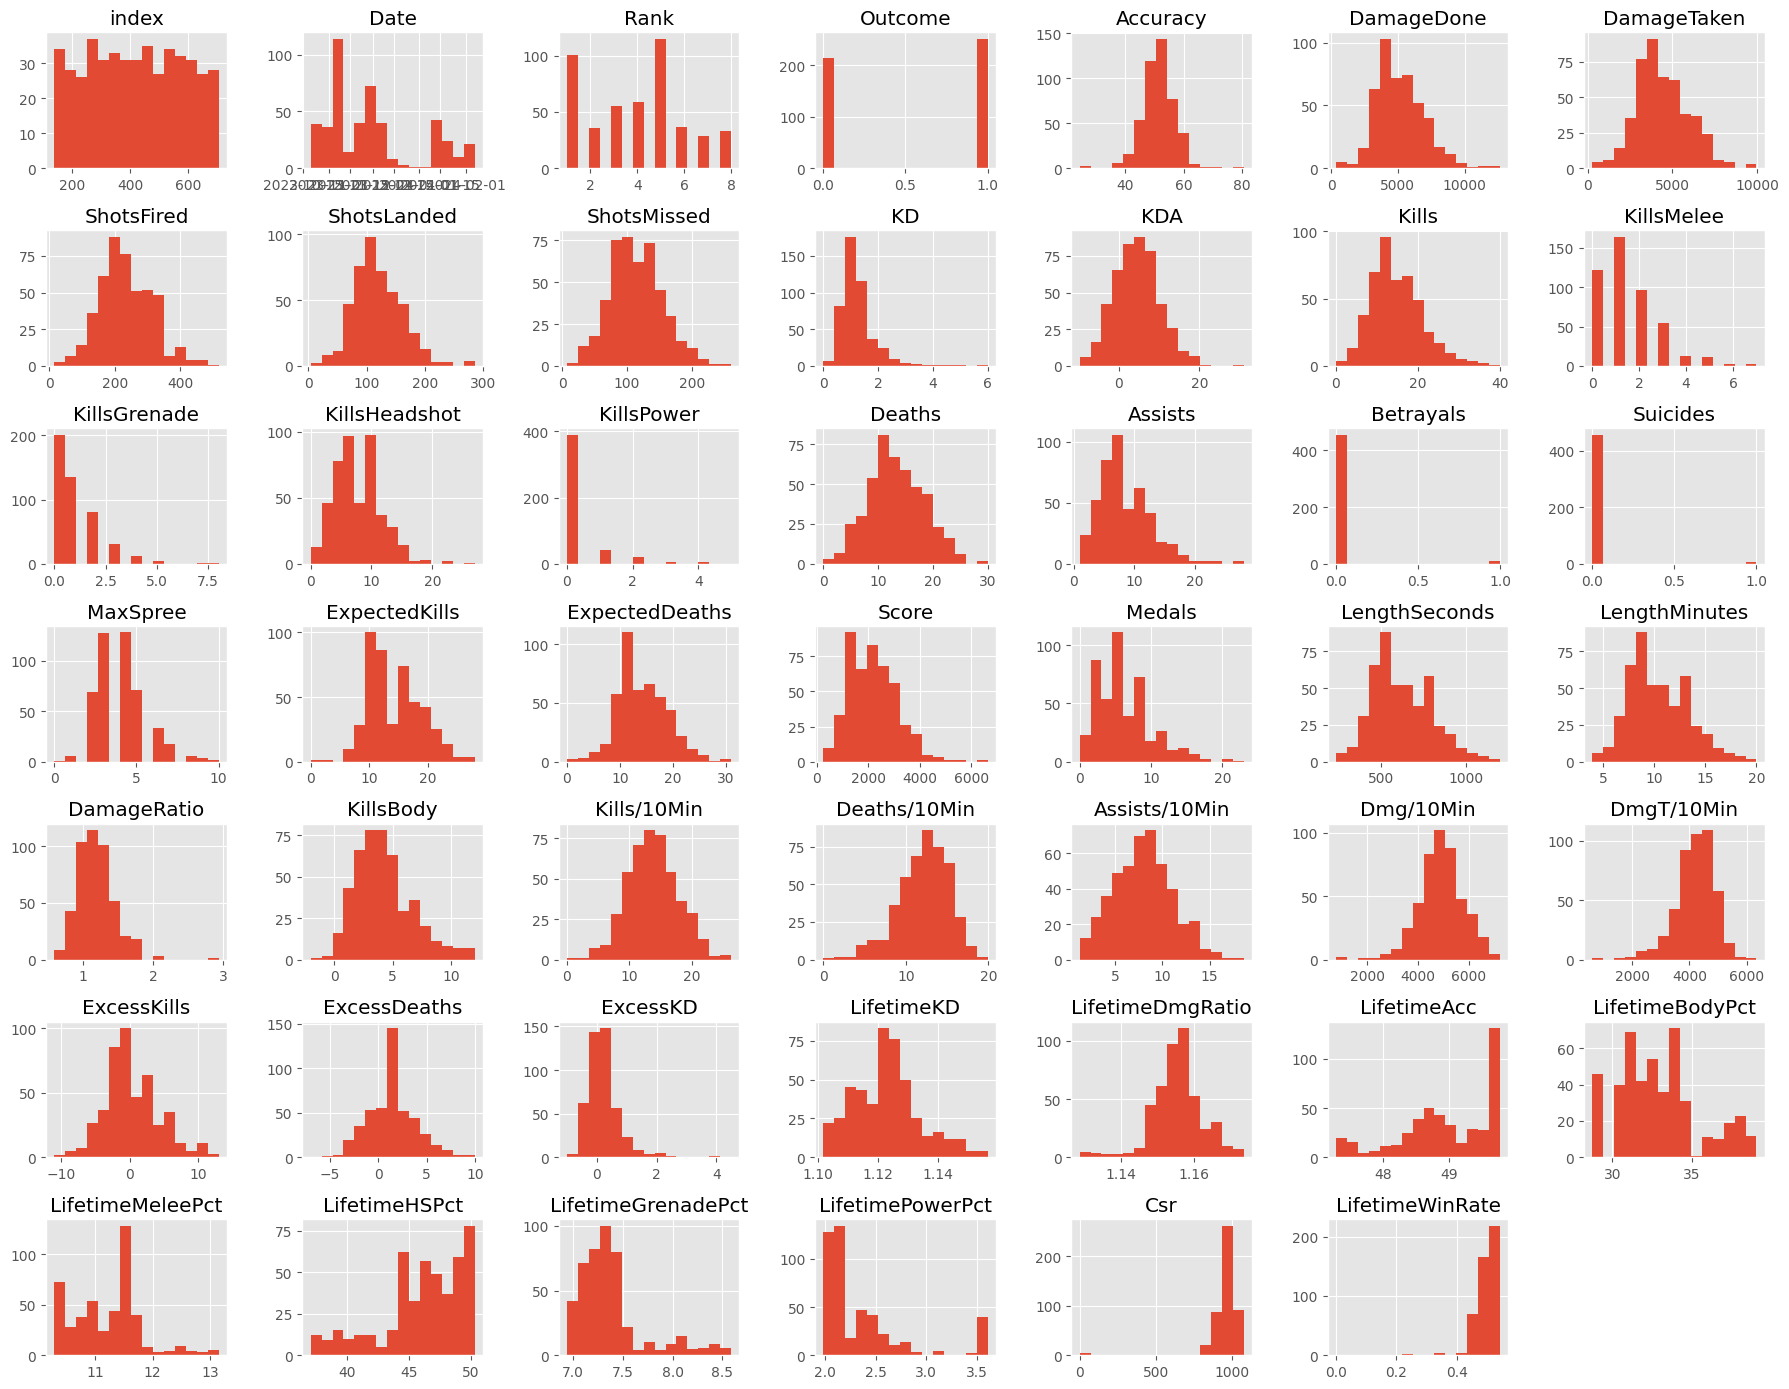

In [127]:
dfr.hist(bins=15, figsize=(18, 14))
plt.tight_layout()
plt.show()

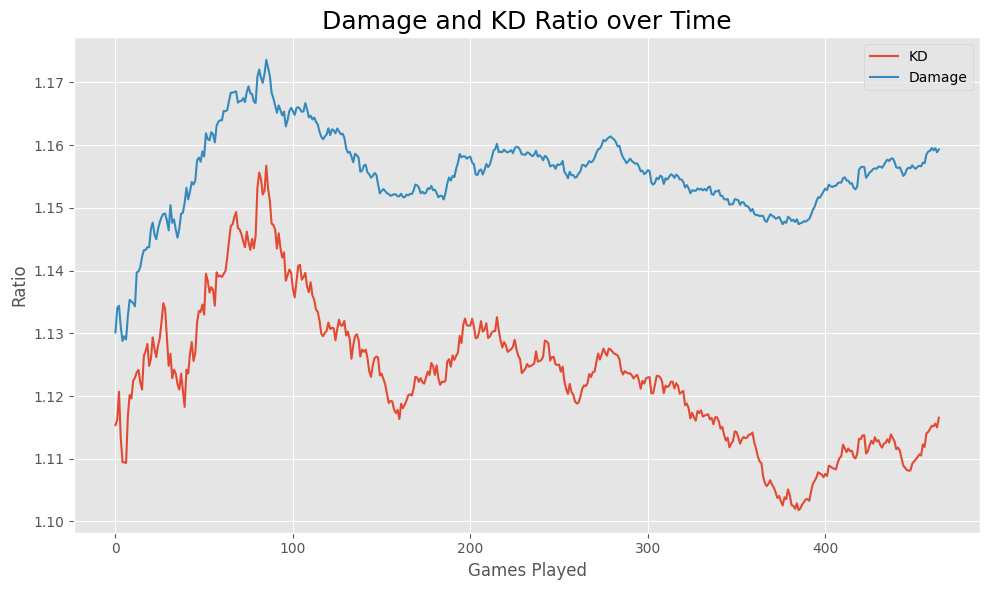

In [128]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeKD'], label='KD' )
plt.plot(dfr['LifetimeDmgRatio'], label='Damage')
plt.title('Damage and KD Ratio over Time', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/DamKDRatios.png', dpi=300)
plt.show()

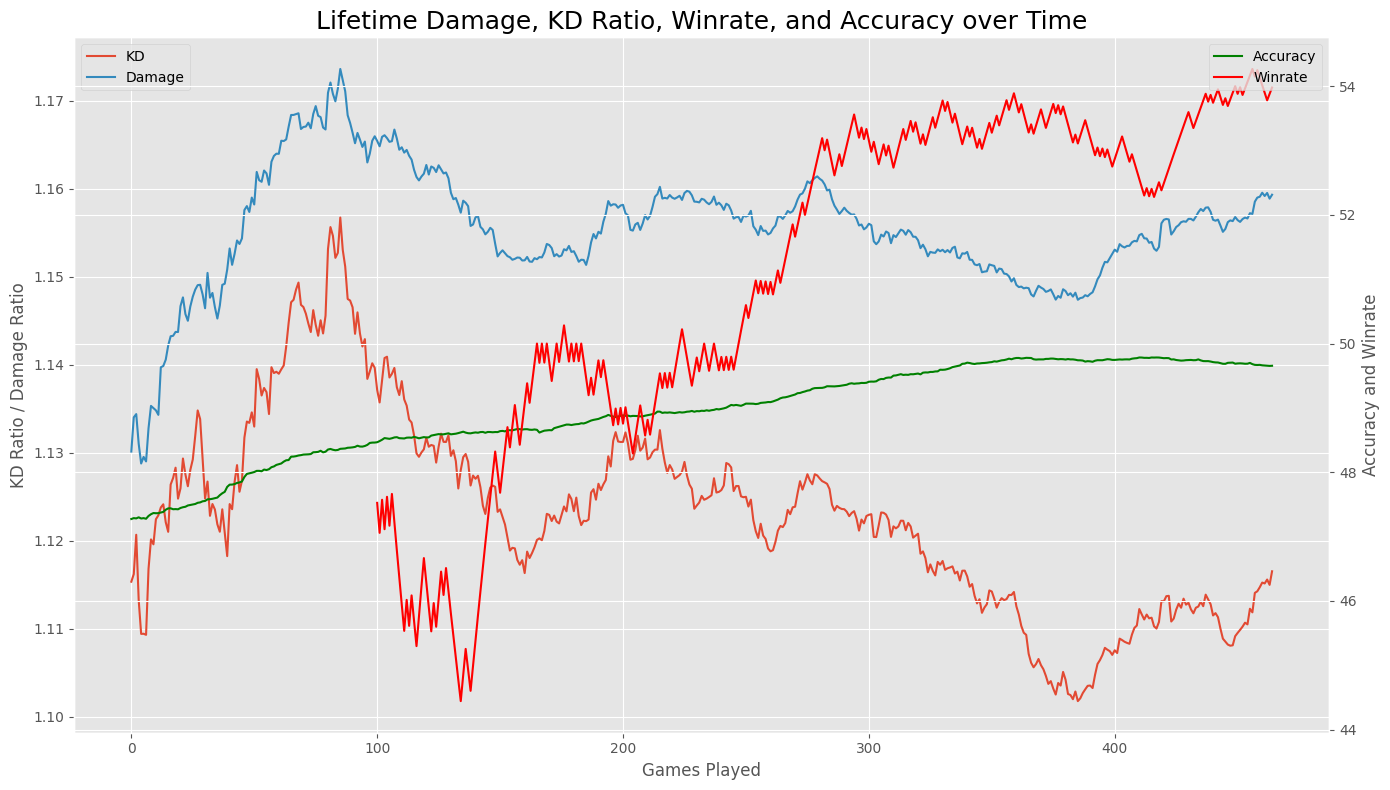

In [129]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedAccuracy'] = dfr['Accuracy'].rolling(window=25).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['LifetimeAcc'], color='green', label='Accuracy')
ax2.plot(dfr['LifetimeWinRate'][100:]*100, color='red', label='Winrate')
ax1.set_title('Lifetime Damage, KD Ratio, Winrate, and Accuracy over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy and Winrate')
# max_y_value = df['LifetimeAcc'].max()
ax1.yaxis.grid(True)
ax2.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDRatiosAcc.png', dpi=300)
plt.show()

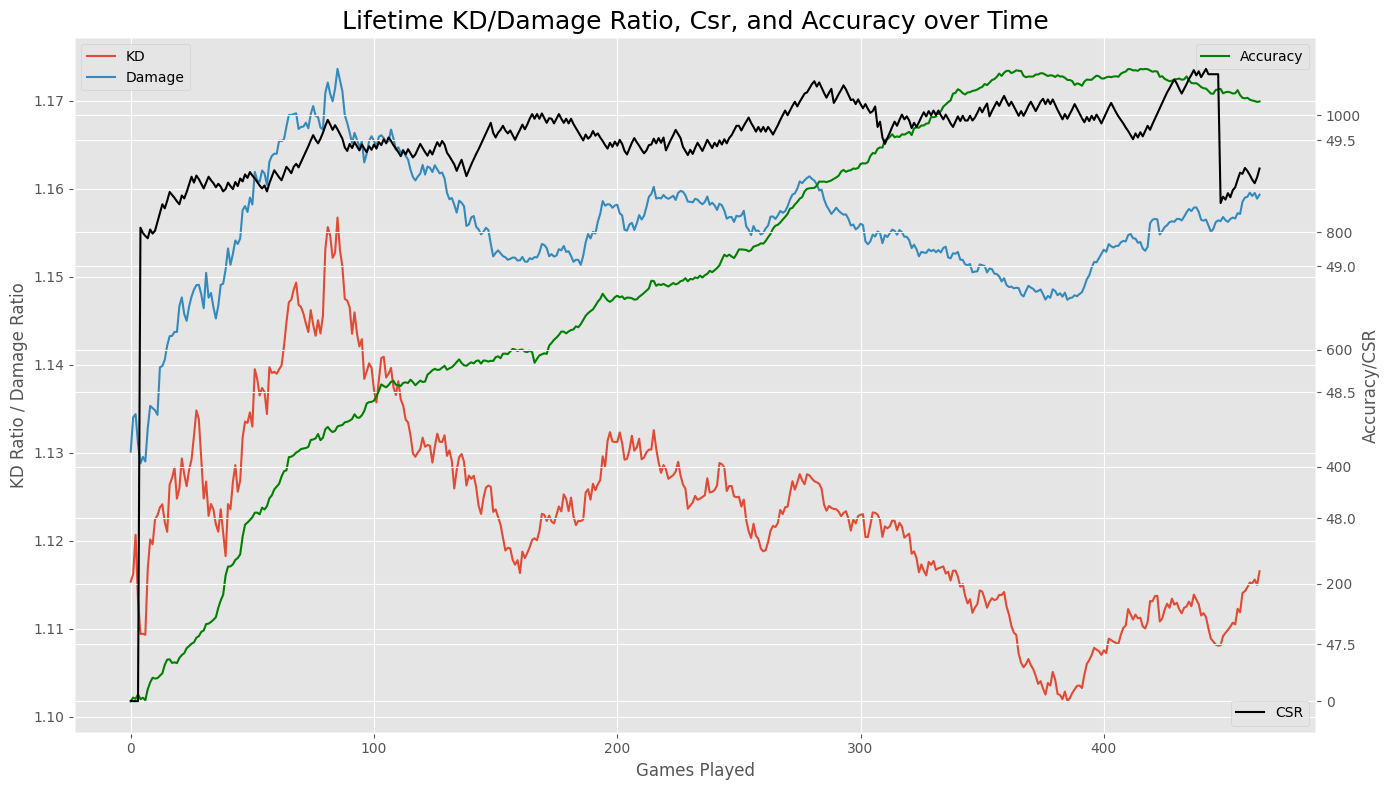

In [130]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedAccuracy'] = dfr['Accuracy'].rolling(window=25).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['LifetimeAcc'], color='green', label='Accuracy')
ax3.plot(dfr['Csr'], label='CSR', color='black')
ax1.set_title('Lifetime KD/Damage Ratio, Csr, and Accuracy over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy/CSR')
# max_y_value = df['LifetimeAcc'].max()
# ax1.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='lower right')
plt.tight_layout()
plt.savefig('Plots/DamKDRatiosAcc.png', dpi=300)
plt.show()

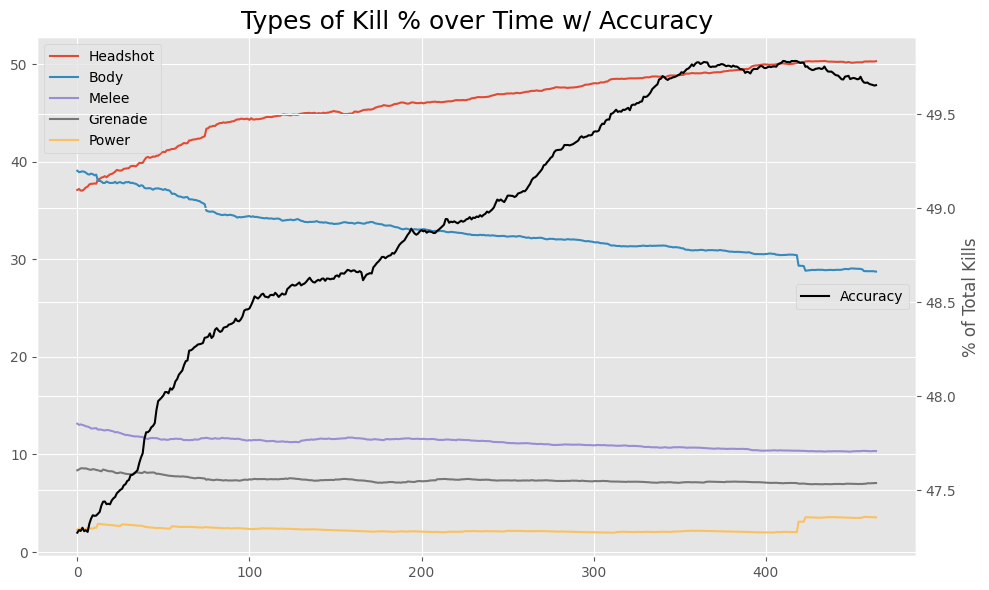

In [131]:
plt.figure(figsize=(10,6))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeHSPct'], label='Headshot')
ax1.plot(dfr['LifetimeBodyPct'], label='Body')
ax1.plot(dfr['LifetimeMeleePct'], label='Melee')
ax1.plot(dfr['LifetimeGrenadePct'], label='Grenade')
ax1.plot(dfr['LifetimePowerPct'], label='Power')
ax2.plot(dfr['LifetimeAcc'], label='Accuracy', color='black')
plt.title('Types of Kill % over Time w/ Accuracy', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('% of Total Kills')
ax1.legend(loc='best')
ax2.legend(loc='right')
ax1.grid(True, axis='y')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatios.png', dpi=300)
plt.show()

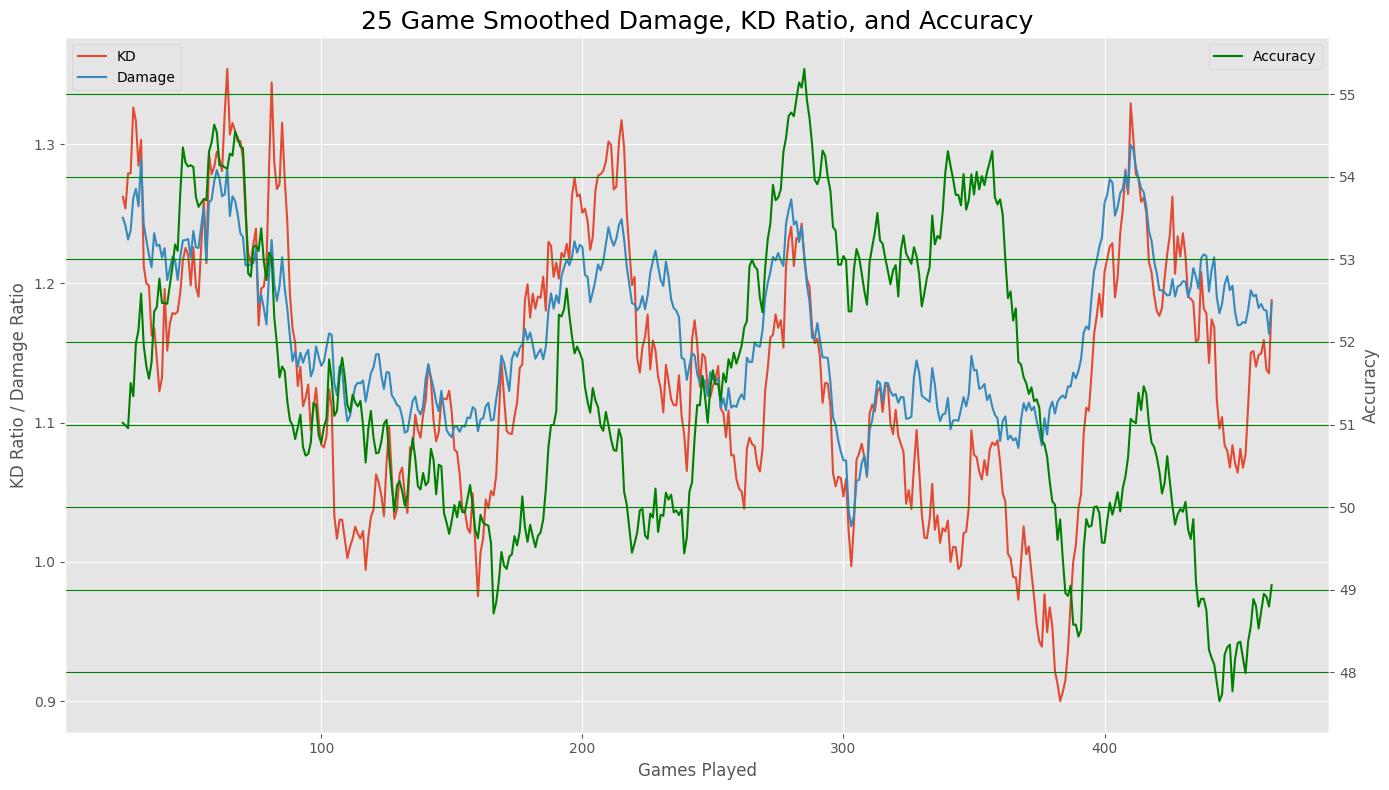

In [132]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 25
dfr['SmoothedAccuracy'] = dfr['ShotsLanded'].rolling(window=roll).sum() / dfr['ShotsFired'].rolling(window=roll).sum() * 100
dfr['SmoothedDmgRatio'] = dfr['DamageDone'].rolling(window=roll).sum() / dfr['DamageTaken'].rolling(window=roll).sum()
dfr['SmoothedKD'] = dfr['Kills'].rolling(window=roll).sum() / dfr['Deaths'].rolling(window=roll).sum()


plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['SmoothedKD'], label='KD' )
ax1.plot(dfr['SmoothedDmgRatio'], label='Damage')
ax2.plot(dfr['SmoothedAccuracy'], color='green', label='Accuracy')
ax1.set_title(f'{roll} Game Smoothed Damage, KD Ratio, and Accuracy', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy')
max_y_value = df['Accuracy'].max()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True, axis='y')
ax2.grid(True, axis='y', color='green')
plt.tight_layout()
plt.savefig('Plots/DamKDRatiosAccSmooth.png', dpi=300)
plt.show()

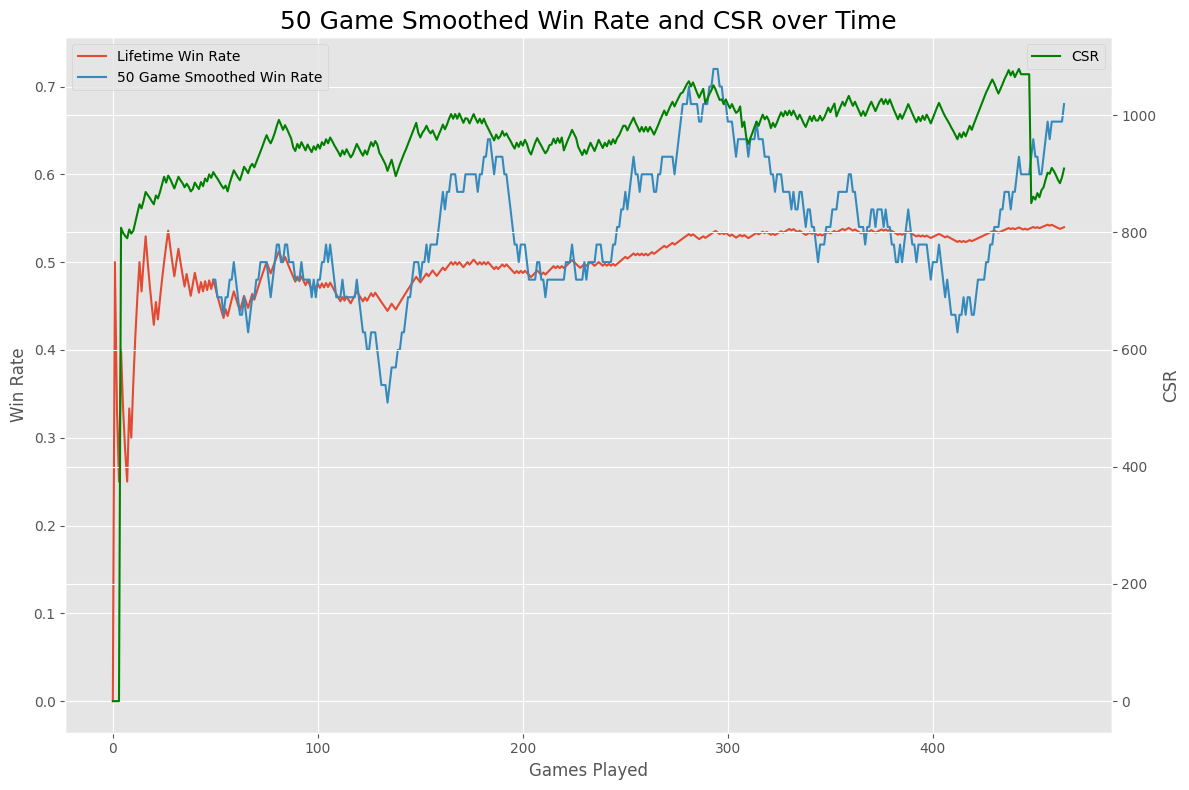

In [133]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedWinRate'] = dfr['LifetimeWinRate'].rolling(window=15).mean()
roll = 50
dfr['SmoothedWinRate'] = dfr['Outcome'].rolling(window=roll).sum() / dfr['Outcome'].rolling(window=roll).count()

plt.figure(figsize=(12,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeWinRate'], label='Lifetime Win Rate' )
ax1.plot(dfr['SmoothedWinRate'], label=(f'{roll} Game Smoothed Win Rate'))
ax2.plot(dfr['Csr'], color='green', label='CSR')
ax1.set_title(f'{roll} Game Smoothed Win Rate and CSR over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('Win Rate')
ax2.set_ylabel('CSR')
ax1.yaxis.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/WinRateCSR.png', dpi=300)
plt.show()

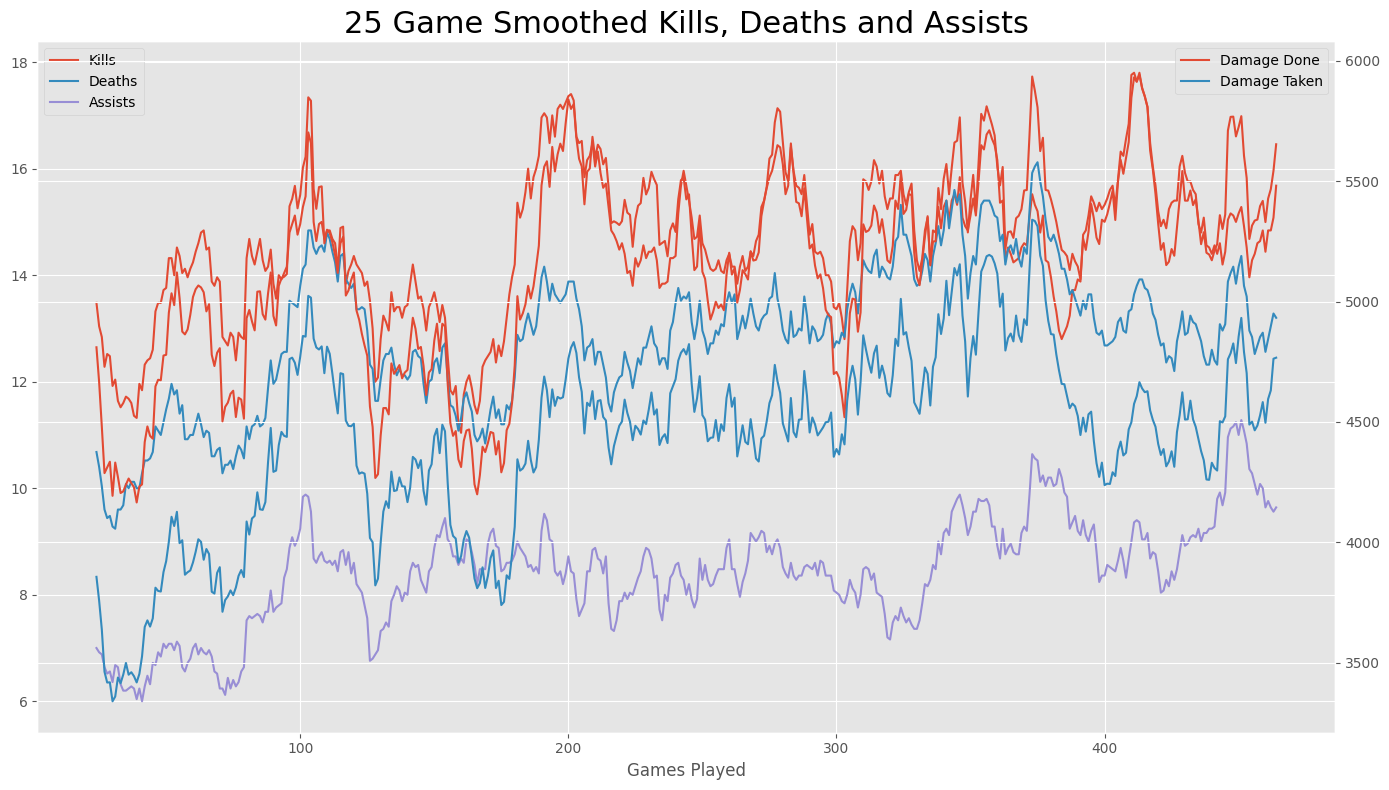

In [134]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 25
dfr['SmoothedKills'] = dfr['Kills'].rolling(window=roll).mean() 
dfr['SmoothedDeaths'] = dfr['Deaths'].rolling(window=roll).mean() 
dfr['SmoothedAssists'] = dfr['Assists'].rolling(window=roll).mean()
dfr['SmoothedDmg'] = dfr['DamageDone'].rolling(window=roll).mean()
dfr['SmoothedDmgT'] = dfr['DamageTaken'].rolling(window=roll).mean()


plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = plt.twinx(ax1)
ax1.plot(dfr['SmoothedKills'], label='Kills' )
ax1.plot(dfr['SmoothedDeaths'], label='Deaths')
ax1.plot(dfr['SmoothedAssists'], label='Assists')
ax2.plot(dfr['SmoothedDmg'], label='Damage Done')
ax2.plot(dfr['SmoothedDmgT'], label='Damage Taken')
ax1.set_title(f'{roll} Game Smoothed Kills, Deaths and Assists', fontsize=22)
ax1.set_xlabel('Games Played')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_facecolor('red')


ax1.yaxis.grid(True)
plt.tight_layout()
plt.savefig('Plots/KDASmooth.png', dpi=300)
plt.show()

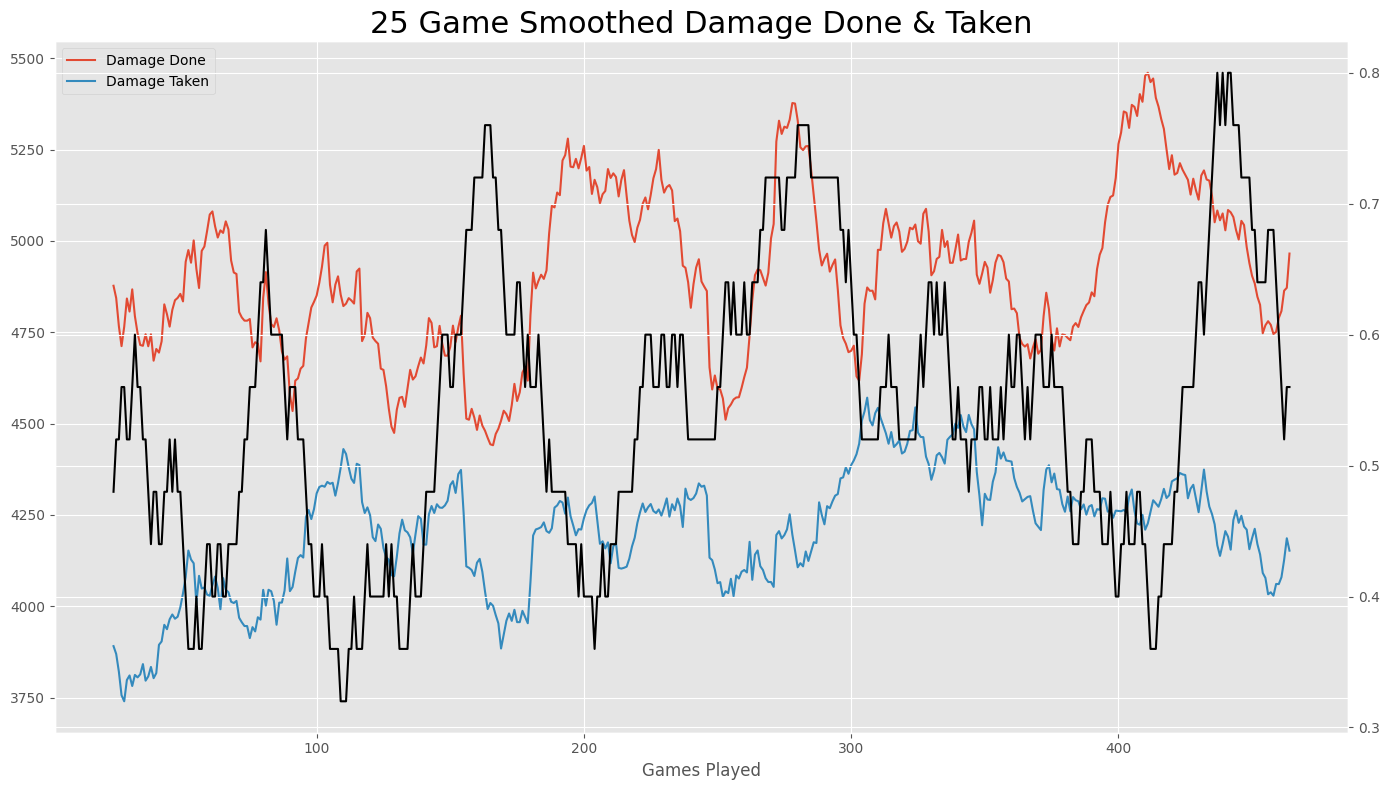

,index,Date,Map,Category,Rank,Outcome,Accuracy,DamageDone,DamageTaken,ShotsFired,...,LifetimeWinRate,SmoothedAccuracy,SmoothedDmgRatio,SmoothedKD,SmoothedWinRate,SmoothedKills,SmoothedDeaths,SmoothedAssists,SmoothedDmg,SmoothedDmgT
0,140,2023-10-19 19:49:41,Solitude,King of the Hill,5,0,52.31,7146,4957,325,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,141,2023-10-19 20:06:10,Solitude,Strongholds,1,1,50.49,7974,5281,309,...,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,142,2023-10-19 20:25:03,Recharge,King of the Hill,5,0,46.36,6889,5906,343,...,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,143,2023-10-19 20:42:40,Streets,Extraction,5,0,53.61,3854,4960,194,...,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,144,2023-10-19 20:55:21,Argyle,CTF 3 Captures,3,1,41.56,2769,3501,231,...,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 25
dfr['SmoothedDmg'] = dfr['Dmg/10Min'].rolling(window=roll).mean()
dfr['SmoothedDmgT'] = dfr['DmgT/10Min'].rolling(window=roll).mean()
dfr['SmoothedWinRate'] = dfr['Outcome'].rolling(window=roll).sum() / dfr['Outcome'].rolling(window=roll).count()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['SmoothedDmg'], label='Damage Done')
ax1.plot(dfr['SmoothedDmgT'], label='Damage Taken')
ax2.plot(dfr['SmoothedWinRate'], label='Winrate', color='black')
ax1.set_title(f'{roll} Game Smoothed Damage Done & Taken', fontsize=22)
ax1.set_xlabel('Games Played')
ax1.legend(loc='upper left')
ax1.yaxis.grid(True)
plt.tight_layout()
plt.savefig('Plots/KDASmooth.png', dpi=300)
plt.show()

dfr.head()

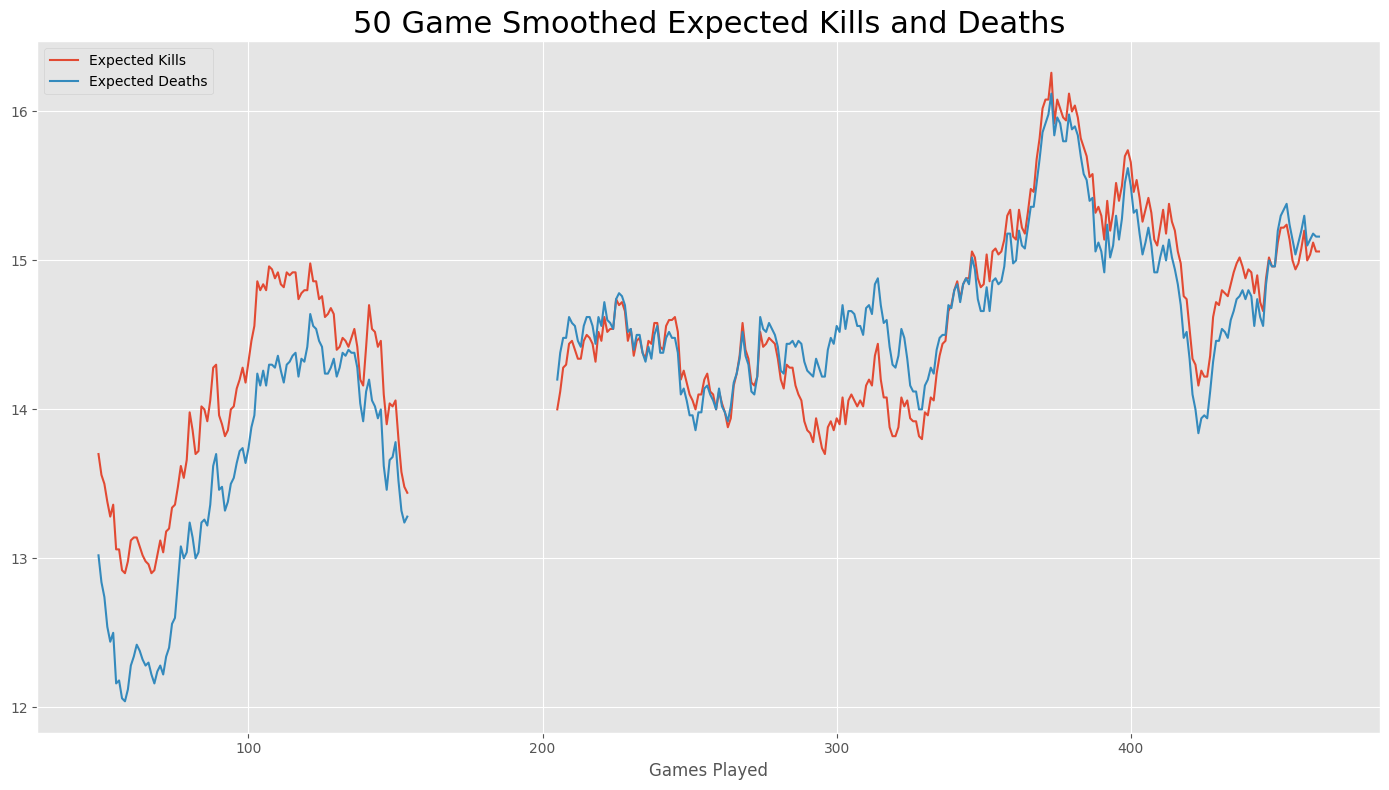

In [136]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 50
dfr['SmoothedExKills'] = dfr['ExpectedKills'].rolling(window=roll).mean()
dfr['SmoothedExDeaths'] = dfr['ExpectedDeaths'].rolling(window=roll).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax1.plot(dfr['SmoothedExKills'], label='Expected Kills')
ax1.plot(dfr['SmoothedExDeaths'], label='Expected Deaths')
ax1.set_title(f'{roll} Game Smoothed Expected Kills and Deaths', fontsize=22)
ax1.set_xlabel('Games Played')
ax1.legend(loc='upper left')
ax1.yaxis.grid(True)
plt.tight_layout()
plt.savefig('Plots/ExKDSmooth.png', dpi=300)
plt.show()

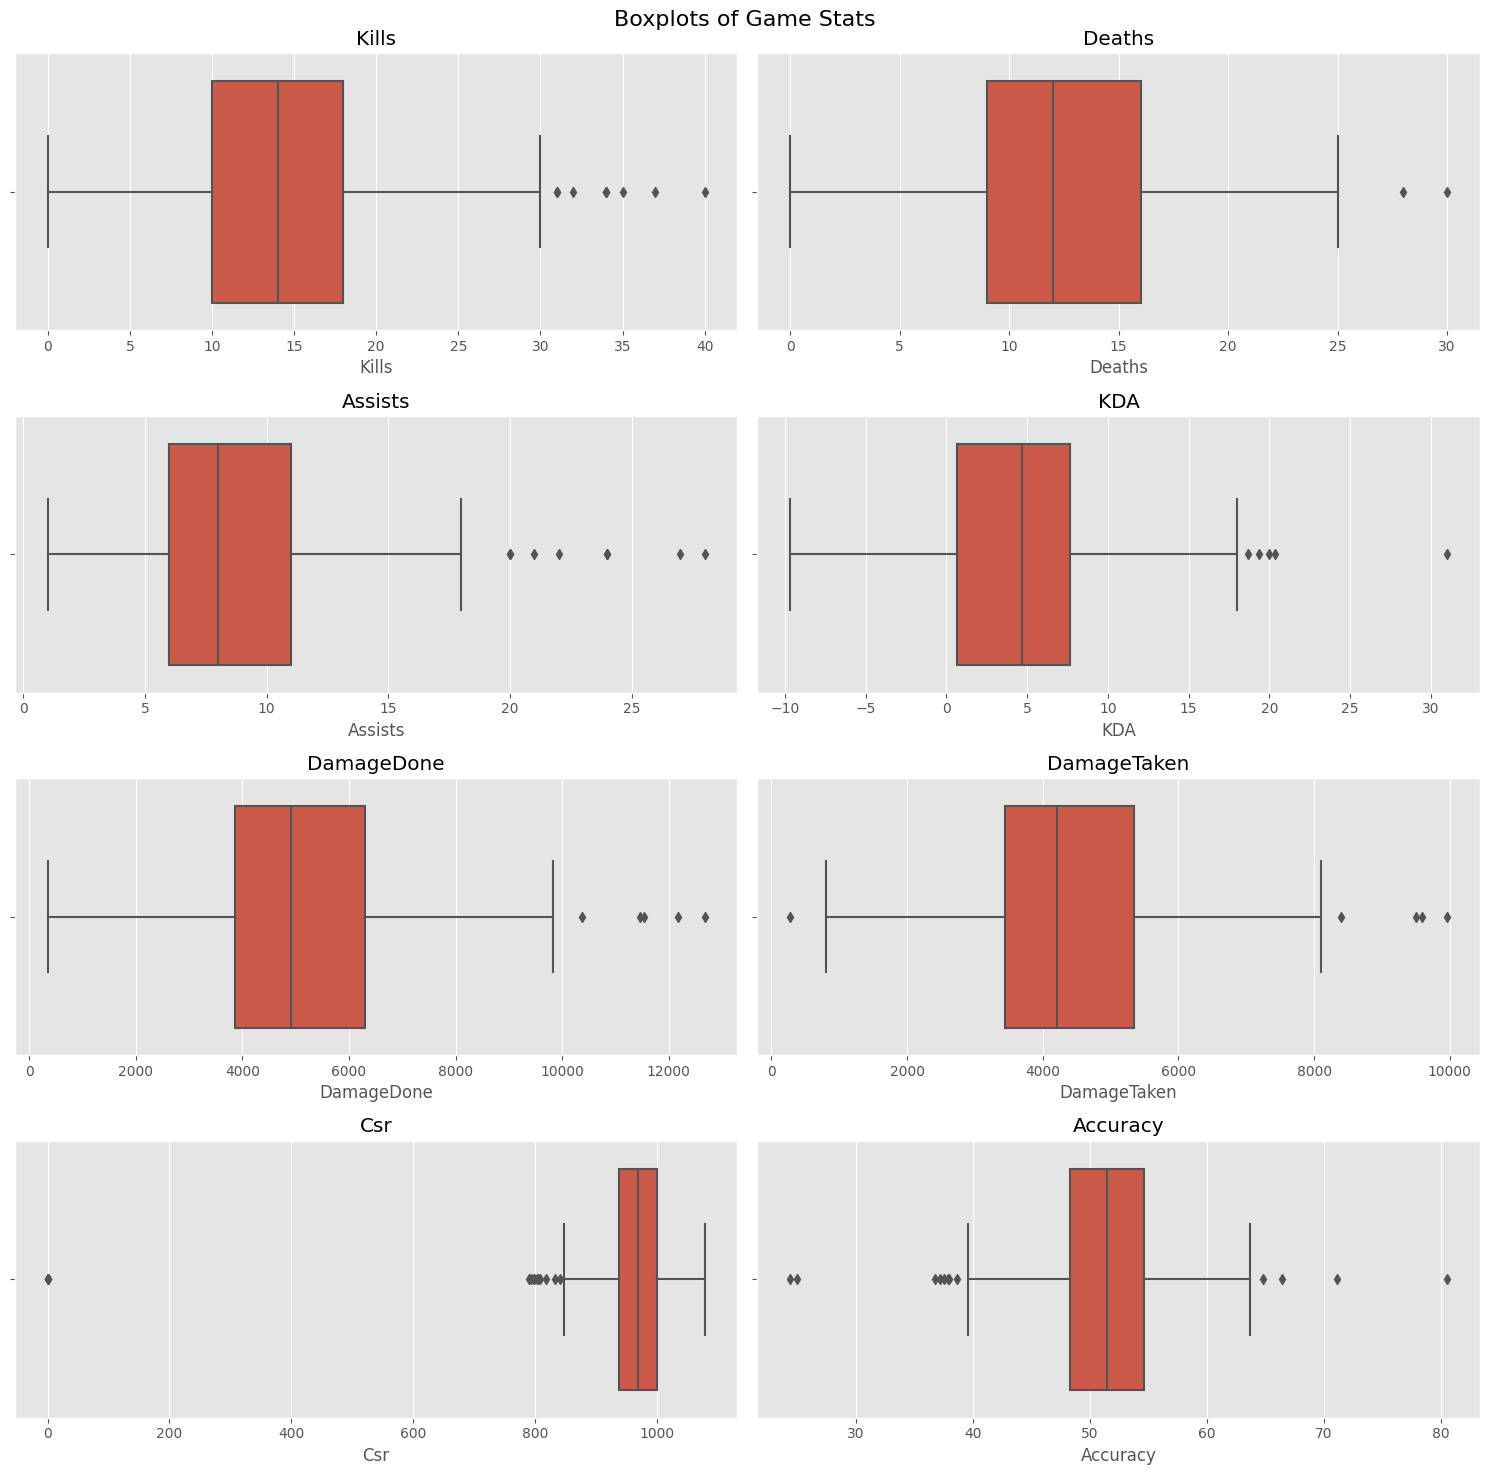

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle('Boxplots of Game Stats', fontsize=16)
plt.tight_layout()
plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


In [138]:
mod = 5

# dfmod = dfr.loc[dfr['Deaths'] < mod, 
#                 ['Kills', 'Deaths', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome']
#                 ].sort_values('DamageDone', ascending=False)

# Column Choice <>
# dfmod = dfr.loc[dfr['Deaths'] < mod]

# Last * Games
dfmod = dfr.tail(mod)

# print(dfmod.head())
print(f'Overall KD: {round(dfmod["Kills"].sum() / dfmod["Deaths"].sum(),2)}')
print(f"Accuracy: {round(dfmod['ShotsLanded'].sum() / dfmod['ShotsFired'].sum()*100,2)}")
print(f"Damage Ratio: {round(dfmod['DamageDone'].sum() / dfmod['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfmod['Outcome']==1).sum()}-{(dfmod['Outcome']==0).sum()}")
print(f"Max CSR: {dfmod['Csr'].max()}")

Overall KD: 1.37
Accuracy: 47.39
Damage Ratio: 1.19
Win-Loss: 2-3
Max CSR: 909


In [139]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills', 'Deaths', 'Assists', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills', 'Deaths', 'Assists', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills', ascending=False)

print('Overall')
print(f'Overall KD: {round(dfr["Kills"].sum() / dfr["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths'].mean(),2)}")
print(f"Average Assists: {round(dfr['Assists'].mean(),2)}")
print(f"Average Accuracy: {round(dfr['ShotsLanded'].sum() / dfr['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills"].sum() / dfw["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths'].mean(),2)}")
print(f"Average Assists: {round(dfw['Assists'].mean(),2)}")
print(f"Average Accuracy: {round(dfw['ShotsLanded'].sum() / dfw['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Wins: {(dfw['Outcome']==1).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills"].sum() / dfl["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths'].mean(),2)}")
print(f"Average Assists: {round(dfl['Assists'].mean(),2)}")
print(f"Average Accuracy: {round(dfl['ShotsLanded'].sum() / dfl['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Losses: {(dfl['Outcome']==0).sum()}")

Overall
Overall KD: 1.14
Average Kills: 14.6
Average Deaths: 12.85
Average Assists: 8.41
Average Accuracy: 51.3
Average Damage Done: 5169
Average Damage Taken: 4427
Damage Ratio: 1.17
Win-Loss: 251-214
----------------------------
Wins
Overall KD: 1.28
Average Kills: 14.39
Average Deaths: 11.28
Average Assists: 8.54
Average Accuracy: 51.43
Average Damage Done: 4990
Average Damage Taken: 4068
Damage Ratio: 1.23
Wins: 251
----------------------------
Losses
Overall KD: 1.01
Average Kills: 14.85
Average Deaths: 14.69
Average Assists: 8.25
Average Accuracy: 51.17
Average Damage Done: 5378
Average Damage Taken: 4849
Damage Ratio: 1.11
Losses: 214


In [140]:
# Create a new column for the combined score in the desired format
dfGami = pd.DataFrame()
dfGami['Kills'] = dfr['Kills']
dfGami['Deaths'] = dfr['Deaths']
dfGami['Assists'] = dfr['Assists']
dfGami['Scorigami'] = dfr['Kills'].astype(str) + '-' + dfr['Deaths'].astype(str) + '-' + dfr['Assists'].astype(str)

# Get unique scorigami scores
scorigami_list = dfGami['Scorigami'].unique()

# Print the scorigami list
# print("Scorigami List:")
# print(scorigami_list)
# print(dfGami.tail())

dfGami = dfGami.sort_values(by=['Kills', 'Deaths', 'Assists'], ascending=False)
print(dfGami.head())
dfGami.to_csv('Scorigami.csv')

     Kills  Deaths  Assists Scorigami
80      40      17       24  40-17-24
310     37      28       17  37-28-17
338     35      25       18  35-25-18
103     34      23        7   34-23-7
392     34      21       15  34-21-15


In [141]:
gamiPiv = dfGami.pivot_table(index='Scorigami', aggfunc='size')

gamiPiv = gamiPiv.sort_index()

print("Records with >1 SS: " ,gamiPiv[gamiPiv.values>1].count())
print(gamiPiv[gamiPiv.values>1].sort_index(ascending=True).sort_values(ascending=False))


Records with >1 SS:  30
Scorigami
7-12-7      3
6-11-8      3
10-5-7      2
10-7-1      2
8-11-5      2
7-8-7       2
7-12-4      2
7-11-6      2
24-19-6     2
21-18-9     2
20-12-6     2
19-18-10    2
17-17-3     2
17-16-11    2
17-14-5     2
16-11-8     2
15-8-7      2
15-13-8     2
15-11-8     2
15-10-14    2
14-14-7     2
14-11-8     2
14-10-11    2
13-14-10    2
13-11-9     2
12-10-6     2
11-8-7      2
11-12-7     2
10-7-5      2
9-11-3      2
dtype: int64


In [142]:
dfrc = dfr.groupby('Category').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthMinutes'] / 60,2)
dfrc['LengthMinutes'] = round(dfrc['LengthMinutes'],2)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['TimeMultiple'] = dfrc['Length%'] - dfrc['Count%']
dfrc.sort_values('Length%', ascending=False)

,LengthMinutes,Count,LengthHours,Length%,Count%,TimeMultiple
Category,,,,,,
Slayer,939.23,109,15.65,19.40,23.44,-4.04
Strongholds,900.02,76,15.00,18.59,16.34,2.25
Oddball,821.00,69,13.68,16.96,14.84,2.12
King of the Hill,693.37,64,11.56,14.32,13.76,0.56
CTF 3 Captures,625.60,57,10.43,12.92,12.26,0.66
Extraction,611.85,70,10.20,12.64,15.05,-2.41
CTF 5 Captures,249.70,20,4.16,5.16,4.30,0.86


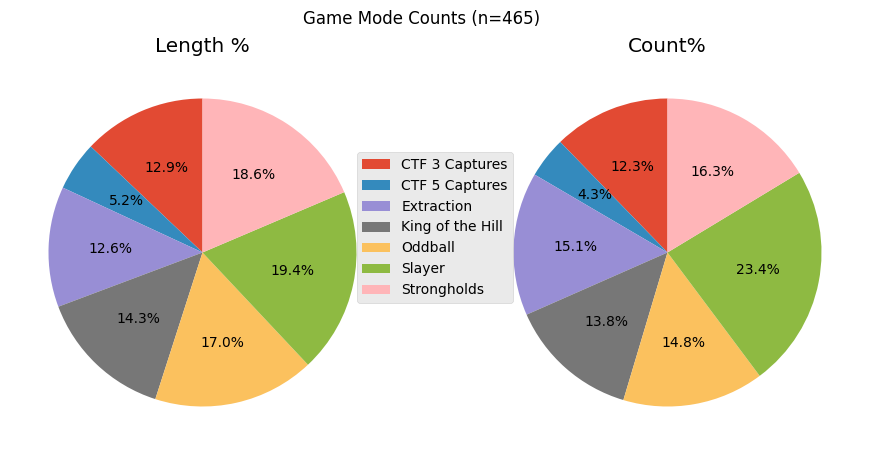

In [143]:
import matplotlib.pyplot as plt

labels = dfrc.index.get_level_values('Category').tolist()
sizes_length = dfrc['Length%'].tolist()
sizes_count = dfrc['Count%'].tolist()
totalcount = dfrc['Count'].sum()

fig, ax = plt.subplots(1, 2, figsize=(11, 5))  # Create a subplot with 1 row and 2 columns
ax[0].pie(sizes_length, labels=None, autopct='%1.1f%%', startangle=90)
ax[1].pie(sizes_count, labels=None, autopct='%1.1f%%', startangle=90)
fig.suptitle(f'Game Mode Counts (n={totalcount})')
ax[0].set(aspect="equal", title='Length %')
ax[1].set(aspect="equal", title='Count%')
fig.legend(labels, loc="center")

plt.show()

In [144]:
dfrc = dfr.groupby(['Category','Map']).agg({'Category': 'count', 'LengthMinutes': 'sum', 'Outcome': 'mean'})
dfrc.rename(columns={'Category': 'Count', 'LengthMinutes': 'LengthHours'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthHours']/60,2)
dfrc['Outcome'] = round(dfrc['Outcome'],2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['Length%'] = round(dfrc['LengthHours'] / dfrc['LengthHours'].sum() * 100,2)
dfrc = dfrc.sort_values(['Length%'], ascending=False)
dfrc

Count  LengthHours  Outcome  Count%  Length%
Category         Map                                                    
Strongholds      Solitude      35         7.47     0.40    7.53     9.26
King of the Hill Recharge      31         6.04     0.55    6.67     7.49
Oddball          Streets       28         5.64     0.54    6.02     6.99
Slayer           Aquarius      35         4.98     0.60    7.53     6.17
                 Solitude      33         4.86     0.58    7.10     6.02
Extraction       Streets       33         4.74     0.61    7.10     5.87
Oddball          Recharge      22         4.31     0.55    4.73     5.34
CTF 5 Captures   Aquarius      20         4.16     0.40    4.30     5.16
CTF 3 Captures   Empyrean      21         3.96     0.43    4.52     4.91
Strongholds      Recharge      21         3.94     0.43    4.52     4.88
Oddball          Live Fire     19         3.74     0.63    4.09     4.64
Strongholds      Live Fire     20         3.59     0.55    4.30     4.45
CTF 3 Captures   Argyle        18         3.40     0.50    3.87     4.21
                 Forbidden     18         3.07     0.61    3.87     3.80
King of the Hill Live Fire     20         3.04     0.75    4.30     3.77
Extraction       Recharge      18         2.76     0.61    3.87     3.42
                 Live Fire     19         2.70     0.42    4.09     3.35
King of the Hill Solitude      13         2.48     0.46    2.80     3.07
Slayer           Live Fire     15         2.20     0.40    3.23     2.73
                 Streets       16         2.09     0.75    3.44     2.59
                 Recharge      10         1.52     0.60    2.15     1.88

In [145]:
dfrcc = dfr.groupby(['Category','Map']).agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'ShotsLanded' : 'sum',
                                             'ShotsFired' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             'LengthMinutes': 'sum',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['Accuracy'] = (dfrcc['ShotsLanded'] / dfrcc['ShotsFired']) *100
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Kills/10Min'] = dfrcc['Kills'] / dfrcc['LengthMinutes'] * 10
dfrcc['Deaths/10Min'] = dfrcc['Deaths'] / dfrcc['LengthMinutes'] * 10
dfrcc['Assists/10Min'] = dfrcc['Assists'] / dfrcc['LengthMinutes'] * 10
dfrcc['KDA/10Min'] = (dfrcc['Kills/10Min'] + (dfrcc['Assists/10Min'] / 3)) / dfrcc['Deaths/10Min'] 
dfrcc = dfrcc.drop(['ShotsLanded', 'ShotsFired'], axis=1)
# dfrcc = round(dfrcc.sort_values(['Winrate', 'Accuracy'], ascending=False),2)
dfrcc = round(dfrcc.sort_values('Accuracy', ascending=False),2)
dfrcc

Count  Kills  Deaths  Assists  DamageDone  \
Category         Map                                                    
Extraction       Live Fire     19    230     216      125       82363   
                 Streets       33    453     351      253      147191   
Oddball          Streets       28    492     444      305      172665   
King of the Hill Live Fire     20    286     261      134       93315   
Strongholds      Solitude      35    679     585      403      231173   
                 Live Fire     20    313     256      124      104497   
CTF 3 Captures   Forbidden     18    249     188      122       88647   
King of the Hill Solitude      13    255     189      125       79048   
Oddball          Live Fire     19    295     293      208      112113   
Extraction       Recharge      18    230     193      143       80159   
CTF 5 Captures   Aquarius      20    394     299      190      131803   
Slayer           Aquarius      35    375     350      224      144316   
CTF 3 Captures   Empyrean      21    311     292      173      110466   
King of the Hill Recharge      31    562     483      372      197641   
Slayer           Solitude      33    350     364      215      136766   
Oddball          Recharge      22    360     304      214      129451   
CTF 3 Captures   Argyle        18    256     220      119       90105   
Slayer           Live Fire     15    153     153       79       56576   
                 Streets       16    147     142      108       59038   
Strongholds      Recharge      21    306     298      200      114450   
Slayer           Recharge      10     92      93       73       41703   

                            DamageTaken  Winrate  LengthMinutes  Accuracy  \
Category         Map                                                        
Extraction       Live Fire        72351     0.42         162.17     55.24   
                 Streets         118482     0.61         284.25     54.27   
Oddball          Streets         149097     0.54         338.37     53.76   
King of the Hill Live Fire        84979     0.75         182.30     53.75   
Strongholds      Solitude        195907     0.40         448.38     52.81   
                 Live Fire        92893     0.55         215.50     52.65   
CTF 3 Captures   Forbidden        68491     0.61         184.12     51.85   
King of the Hill Solitude         65007     0.46         148.55     51.63   
Oddball          Live Fire        94966     0.63         224.22     51.57   
Extraction       Recharge         66596     0.61         165.43     51.43   
CTF 5 Captures   Aquarius        103529     0.40         249.70     51.33   
Slayer           Aquarius        127422     0.60         299.02     50.85   
CTF 3 Captures   Empyrean         99580     0.43         237.53     50.61   
King of the Hill Recharge        164900     0.55         362.52     50.59   
Slayer           Solitude        127594     0.58         291.73     50.01   
Oddball          Recharge        107639     0.55         258.42     49.16   
CTF 3 Captures   Argyle           76644     0.50         203.95     48.98   
Slayer           Live Fire        54644     0.40         131.95     48.52   
                 Streets          51569     0.75         125.57     48.14   
Strongholds      Recharge         99050     0.43         236.13     48.14   
Slayer           Recharge         37402     0.60          90.97     47.45   

                              KD  DamageRatio  Dmg/Life  ExDmg/Life  \
Category         Map                                                  
Extraction       Live Fire  1.06         1.14    381.31       46.35   
                 Streets    1.29         1.24    419.35       81.79   
Oddball          Streets    1.11         1.16    388.89       53.08   
King of the Hill Live Fire  1.10         1.10    357.53       31.94   
Strongholds      Solitude   1.16         1.18    395.17       60.28   
                 Live Fire  1.22         1.12    408.19       45.33   
CTF 3 Ca

In [149]:
dfrcc = dfr.groupby('Category').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Assists/Life', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Category,,,,,,,,,,,,
Oddball,69,1147,1041,727,414229,351702,0.57,1.10,1.18,397.91,60.06,0.70
Extraction,70,913,760,521,309713,257429,0.56,1.20,1.20,407.52,68.79,0.69
King of the Hill,64,1103,933,631,370004,314886,0.59,1.18,1.18,396.57,59.08,0.68
Strongholds,76,1298,1139,727,450120,387850,0.45,1.14,1.16,395.19,54.67,0.64
CTF 5 Captures,20,394,299,190,131803,103529,0.40,1.32,1.27,440.81,94.56,0.64
Slayer,109,1117,1102,699,438399,398631,0.59,1.01,1.10,397.82,36.09,0.63
CTF 3 Captures,57,816,700,414,289218,244715,0.51,1.17,1.18,413.17,63.58,0.59


In [147]:
dfrcc = dfr.groupby('Map').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Assists/Life', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Map,,,,,,,,,,,,
Recharge,102,1550,1371,1002,563404,475587,0.54,1.13,1.18,410.94,64.05,0.73
Streets,77,1092,937,666,378894,319148,0.61,1.17,1.19,404.37,63.76,0.71
Solitude,81,1284,1138,743,446987,388508,0.48,1.13,1.15,392.78,51.39,0.65
Forbidden,18,249,188,122,88647,68491,0.61,1.32,1.29,471.53,107.21,0.65
Aquarius,55,769,649,414,276119,230951,0.53,1.18,1.20,425.45,69.60,0.64
Empyrean,21,311,292,173,110466,99580,0.43,1.07,1.11,378.31,37.28,0.59
Live Fire,93,1277,1179,670,448864,399833,0.56,1.08,1.12,380.72,41.59,0.57
Argyle,18,256,220,119,90105,76644,0.50,1.16,1.18,409.57,61.19,0.54


In [148]:
print(f'Runtime: {time.perf_counter() - start}s')

Runtime: 10.829856625001412s
